In [1]:
from pathlib import Path

import pingouin as pg
from scipy.stats import shapiro

%reload_ext autoreload
%autoreload 2

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

import acr

warnings.filterwarnings("ignore")

In [2]:
import pubplots as pp

from acr.utils import NNXR_GRAY, NREM_RED, PAPER_FIGURE_ROOT, SOM_BLUE, ACR_BLUE, HALO_GREEN, CTRL_BLUE

style_path = "/Users/driessen2@ad.wisc.edu/kdriessen/acr_dev/acr/src/acr/plot_styles/acrvec_labels.mplstyle"


# -------------------- ADJUST HERE --------------------
nbroot = os.path.join(PAPER_FIGURE_ROOT, "response_to_review", "sleep_architecture")
Path(nbroot).mkdir(parents=True, exist_ok=True)

In [3]:
pub_utils = acr.utils.import_publication_functions(
    "/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/pub_utils.py",
    "pub_utils",
)
import pub_utils as pu

data_agg = acr.utils.import_publication_functions(
    "/Users/driessen2@ad.wisc.edu/kdriessen/gh_master/PUBLICATION__ACR/data_agg.py",
    "data_agg",
)
import data_agg as dag

In [4]:
subtypes = ['som', 'acr', 'halo', 'control']
expnames = ['swi', 'swi', 'swisin', 'swi']

In [5]:
hds = {}
h = {}

for subject_type, main_exp in zip(subtypes, expnames):
    subjects, exps = pu.get_subject_list(type=subject_type, exp=main_exp)
    for subject, exp in zip(subjects, exps):
        try:
            h[subject] = acr.io.load_hypno_full_exp(subject, exp, update=False)
            hds[subject] = acr.hypnogram_utils.create_hyp_dict_fast(subject, exp, 
                                                                    h=h[subject], 
                                                                    true_stim=False, 
                                                                    duration='3600s')
        except Exception as e:
            print(f"Error loading hypno for {subject} {exp}: {e}")
            continue

In [33]:
recovery_duration = '1h'
fracs = []
for subject in hds.keys():
    st = acr.utils.sub_exp_types[subject]
    reb_start = hds[subject]['rebound'].start_time.min()
    reb_end = reb_start + pd.Timedelta(recovery_duration)
    hf = h[subject]
    fo = hf.trim_select(start=reb_start, end=reb_end).fractional_occupancy()
    fo = fo.to_frame().reset_index(drop=False)
    fo = fo.sort_values(by='duration', ascending=False)
    for anst in ['Wake', 'NREM', 'REM', 'Transition-to-REM']:
        if anst not in fo['state'].unique():
            st_df = pd.DataFrame({'state': anst, 'duration': 0}, index=[0])
            fo = pd.concat([fo, st_df])
    fo['subject'] = subject
    fo['sub_type'] = st
    fracs.append(fo)

fo = pd.concat(fracs)

# NREM

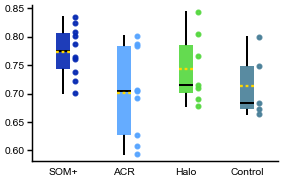

In [34]:
state = 'NREM'
fig_name = f"{state}_sleep_fraction_of_pure_1hr"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
data = fo.loc[(fo['state'] == state)]
# data = fo.loc[(fo['state'] == 'NREM') | (fo['state'] == 'Art')]

# data = data.groupby(['subject', 'sub_type']).agg({'duration': 'sum'})
# data = data.reset_index(drop=False)



som = data.loc[data['sub_type'] == 'som']['duration'].to_numpy()
ac = data.loc[data['sub_type'] == 'acr']['duration'].to_numpy()
halo = data.loc[data['sub_type'] == 'halo']['duration'].to_numpy()
ctrl = data.loc[data['sub_type'] == 'control']['duration'].to_numpy()

with pp.destination("figma", style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2.0, 1.33))
    
    ax, box = acr.plots.add_boxplot(
        ax,
        som,
        positions=[0.4],
        widths=0.0225,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som, x_pos=0.42, color=SOM_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ac,
        positions=[.5],
        widths=0.0225,
        color=ACR_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ac, x_pos=0.52, color=ACR_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        halo,
        positions=[0.6],
        widths=0.0225,
        color=HALO_GREEN,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, halo, x_pos=0.62, color=HALO_GREEN, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl,
        positions=[0.7],
        widths=0.0225,
        color=CTRL_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl, x_pos=0.72, color=CTRL_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax.set_xlim(0.35, 0.75)
    ax.set_xticklabels(['SOM+', 'ACR', 'Halo', 'Control'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [35]:
stat_name = fig_name

_, p = shapiro(som)
print(f"p-value: {p}")

_, p = shapiro(ac)
print(f"p-value: {p}")

_, p = shapiro(halo)
print(f"p-value: {p}")

_, p = shapiro(ctrl)
print(f"p-value: {p}")
stat = pg.anova(data=data, dv='duration', between='sub_type')
acr.stats.write_stats_result(
    stat_name,
    "ANOVA",
    test_statistic=stat["F"][0],
    p_value=stat["p-unc"][0],
    effect_size_method="np2",
    effect_size=stat["np2"][0],
    review=True,
)
srcdat = data.drop(columns=['subject'])
pu.write_source_data(srcdat, stat_name)
stat

p-value: 0.8282396746947176
p-value: 0.26548581827590506
p-value: 0.4129909847855418
p-value: 0.21208071775704235


,Source,ddof1,ddof2,F,p-unc,np2
0,sub_type,3,27,2.459621,0.084306,0.214634


# REM

In [36]:
state = 'REM'
fig_name = f"{state}_sleep_fraction_of_pure_1hr"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
data = fo.loc[(fo['state'] == state) | (fo['state'] == 'Transition-to-REM')]
#data = fo.loc[(fo['state'] == state)]
# data = fo.loc[(fo['state'] == 'NREM') | (fo['state'] == 'Art')]

# data = data.groupby(['subject', 'sub_type']).agg({'duration': 'sum'})
# data = data.reset_index(drop=False)

In [37]:
data = data.groupby(['subject', 'sub_type'])['duration'].sum().reset_index()

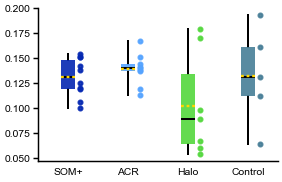

In [38]:



som = data.loc[data['sub_type'] == 'som']['duration'].to_numpy()
ac = data.loc[data['sub_type'] == 'acr']['duration'].to_numpy()
halo = data.loc[data['sub_type'] == 'halo']['duration'].to_numpy()
ctrl = data.loc[data['sub_type'] == 'control']['duration'].to_numpy()

with pp.destination("figma", style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2.0, 1.33))
    
    ax, box = acr.plots.add_boxplot(
        ax,
        som,
        positions=[0.4],
        widths=0.0225,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som, x_pos=0.42, color=SOM_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ac,
        positions=[.5],
        widths=0.0225,
        color=ACR_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ac, x_pos=0.52, color=ACR_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        halo,
        positions=[0.6],
        widths=0.0225,
        color=HALO_GREEN,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, halo, x_pos=0.62, color=HALO_GREEN, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl,
        positions=[0.7],
        widths=0.0225,
        color=CTRL_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl, x_pos=0.72, color=CTRL_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax.set_xlim(0.35, 0.75)
    ax.set_xticklabels(['SOM+', 'ACR', 'Halo', 'Control'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [39]:
stat_name = fig_name

_, p = shapiro(som)
print(f"p-value: {p}")

_, p = shapiro(ac)
print(f"p-value: {p}")

_, p = shapiro(halo)
print(f"p-value: {p}")

_, p = shapiro(ctrl)
print(f"p-value: {p}")
stat = pg.anova(data=data, dv='duration', between='sub_type')
acr.stats.write_stats_result(
    stat_name,
    "ANOVA",
    test_statistic=stat["F"][0],
    p_value=stat["p-unc"][0],
    effect_size_method="np2",
    effect_size=stat["np2"][0],
    review=True,
)
srcdat = data.drop(columns=['subject'])
pu.write_source_data(srcdat, stat_name)
stat

p-value: 0.40493642146032216
p-value: 0.515087484004921
p-value: 0.08699132897981329
p-value: 0.9892696804818121


,Source,ddof1,ddof2,F,p-unc,np2
0,sub_type,3,27,1.658601,0.199383,0.155612


# Wake

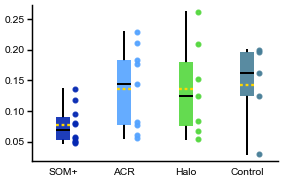

In [40]:
state = 'Wake'
fig_name = f"{state}_sleep_fraction_of_pure_1hr"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
data = fo.loc[(fo['state'] == state)]
# data = fo.loc[(fo['state'] == 'NREM') | (fo['state'] == 'Art')]

# data = data.groupby(['subject', 'sub_type']).agg({'duration': 'sum'})
# data = data.reset_index(drop=False)



som = data.loc[data['sub_type'] == 'som']['duration'].to_numpy()
ac = data.loc[data['sub_type'] == 'acr']['duration'].to_numpy()
halo = data.loc[data['sub_type'] == 'halo']['duration'].to_numpy()
ctrl = data.loc[data['sub_type'] == 'control']['duration'].to_numpy()

with pp.destination("figma", style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2.0, 1.33))
    
    ax, box = acr.plots.add_boxplot(
        ax,
        som,
        positions=[0.4],
        widths=0.0225,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som, x_pos=0.42, color=SOM_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ac,
        positions=[.5],
        widths=0.0225,
        color=ACR_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ac, x_pos=0.52, color=ACR_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        halo,
        positions=[0.6],
        widths=0.0225,
        color=HALO_GREEN,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, halo, x_pos=0.62, color=HALO_GREEN, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl,
        positions=[0.7],
        widths=0.0225,
        color=CTRL_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl, x_pos=0.72, color=CTRL_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax.set_xlim(0.35, 0.75)
    ax.set_xticklabels(['SOM+', 'ACR', 'Halo', 'Control'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [41]:
stat_name = fig_name

_, p = shapiro(som)
print(f"p-value: {p}")

_, p = shapiro(ac)
print(f"p-value: {p}")

_, p = shapiro(halo)
print(f"p-value: {p}")

_, p = shapiro(ctrl)
print(f"p-value: {p}")
stat = pg.anova(data=data, dv='duration', between='sub_type')
acr.stats.write_stats_result(
    stat_name,
    "ANOVA",
    test_statistic=stat["F"][0],
    p_value=stat["p-unc"][0],
    effect_size_method="np2",
    effect_size=stat["np2"][0],
    review=True,
)
srcdat = data.drop(columns=['subject'])
pu.write_source_data(srcdat, stat_name)
stat

p-value: 0.10220795943083888
p-value: 0.2047299370308821
p-value: 0.5184430488268231
p-value: 0.2475020764343136


,Source,ddof1,ddof2,F,p-unc,np2
0,sub_type,3,27,2.224167,0.108276,0.198159


# Bout duration

In [42]:
fracs = []
for subject in hds.keys():
    st = acr.utils.sub_exp_types[subject]
    avg_bout_dur = hds[subject]['rebound']['duration'].mean()
    avg_bout_dur = avg_bout_dur.total_seconds()
    bd = pd.DataFrame({'subject': subject, 'sub_type': st, 'avg_bout_dur': avg_bout_dur}, index=[0])
    fracs.append(bd)

fo = pd.concat(fracs)
fo

,subject,sub_type,avg_bout_dur
0,ACR_25,som,156.521739
0,ACR_26,som,94.736842
0,ACR_29,som,120.000000
0,ACR_30,som,85.714285
0,ACR_35,som,78.260869
0,ACR_37,som,120.000000
0,ACR_39,som,128.571428
0,ACR_40,som,69.230769
0,ACR_41,som,85.714285
0,ACR_44,som,144.000000


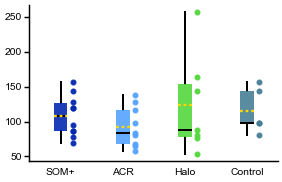

In [43]:
data = fo
fig_name = "nrem_bout_duration_1hr_nrem_rebound"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
som = data.loc[data['sub_type'] == 'som']['avg_bout_dur'].to_numpy()
ac = data.loc[data['sub_type'] == 'acr']['avg_bout_dur'].to_numpy()
halo = data.loc[data['sub_type'] == 'halo']['avg_bout_dur'].to_numpy()
ctrl = data.loc[data['sub_type'] == 'control']['avg_bout_dur'].to_numpy()

with pp.destination("figma", style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2.0, 1.33))
    
    ax, box = acr.plots.add_boxplot(
        ax,
        som,
        positions=[0.4],
        widths=0.0225,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som, x_pos=0.42, color=SOM_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ac,
        positions=[.5],
        widths=0.0225,
        color=ACR_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ac, x_pos=0.52, color=ACR_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        halo,
        positions=[0.6],
        widths=0.0225,
        color=HALO_GREEN,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, halo, x_pos=0.62, color=HALO_GREEN, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl,
        positions=[0.7],
        widths=0.0225,
        color=CTRL_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl, x_pos=0.72, color=CTRL_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax.set_xlim(0.35, 0.75)
    ax.set_xticklabels(['SOM+', 'ACR', 'Halo', 'Control'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [44]:
stat_name = fig_name

_, p = shapiro(som)
print(f"p-value: {p}")

_, p = shapiro(ac)
print(f"p-value: {p}")

_, p = shapiro(halo)
print(f"p-value: {p}")

_, p = shapiro(ctrl)
print(f"p-value: {p}")
stat = pg.anova(data=data, dv='avg_bout_dur', between='sub_type')
acr.stats.write_stats_result(
    stat_name,
    "ANOVA",
    test_statistic=stat["F"][0],
    p_value=stat["p-unc"][0],
    effect_size_method="np2",
    effect_size=stat["np2"][0],
    review=True,
)
srcdat = data.drop(columns=['subject'])
pu.write_source_data(srcdat, stat_name)
stat

p-value: 0.5163293615871067
p-value: 0.43149494801250726
p-value: 0.19644130959041267
p-value: 0.2830212341334293


,Source,ddof1,ddof2,F,p-unc,np2
0,sub_type,3,27,0.727081,0.544741,0.074748


# Number of brief arousals

In [45]:
recovery_duration = '1h'
fracs = []
for subject in hds.keys():
    st = acr.utils.sub_exp_types[subject]
    reb_start = hds[subject]['rebound']['start_time'].min()
    reb_end = hds[subject]['rebound']['end_time'].max()
    hf = h[subject]
    hr = hf.trim_select(start=reb_start, end=reb_start + pd.Timedelta('1h'))
    w = hr.loc[(hr['state']=='Wake')|(hr['state']=='Brief-Arousal')]
    ba_candidates = w.loc[w.duration < pd.Timedelta(5, unit='s')]
    print(len(ba_candidates))
    # Filter to only include brief arousals preceded and followed by NREM
    valid_ba_indices = []
    for idx in ba_candidates.index:
        iloc_pos = hr.index.get_loc(idx)
        if iloc_pos > 0 and iloc_pos < len(hr) - 1:
            prev_state = hr.iloc[iloc_pos - 1]['state']
            next_state = hr.iloc[iloc_pos + 1]['state']
            if prev_state == 'NREM' and next_state == 'NREM':
                valid_ba_indices.append(idx)
    ba = ba_candidates.loc[valid_ba_indices]
    num_ba = len(ba)
    print(num_ba)
    bd = pd.DataFrame({'subject': subject, 'sub_type': st, 'num_ba': num_ba}, index=[0])
    fracs.append(bd)
fo = pd.concat(fracs)
fo

7
7
8
8
10
9
7
7
15
15
8
8
4
4
10
9
20
20
8
8
1
1
11
11
1
1
1
1
0
0
8
7
4
2
4
4
6
5
4
4
2
2
0
0
15
14
15
15
17
14
19
17
8
7
1
1
8
8
11
11
14
14


,subject,sub_type,num_ba
0,ACR_25,som,7
0,ACR_26,som,8
0,ACR_29,som,9
0,ACR_30,som,7
0,ACR_35,som,15
0,ACR_37,som,8
0,ACR_39,som,4
0,ACR_40,som,9
0,ACR_41,som,20
0,ACR_44,som,8


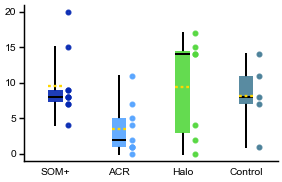

In [46]:
data = fo
fig_name = "brief_arousal_incidence_1hr_nrem_rebound"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
som = data.loc[data['sub_type'] == 'som']['num_ba'].to_numpy()
ac = data.loc[data['sub_type'] == 'acr']['num_ba'].to_numpy()
halo = data.loc[data['sub_type'] == 'halo']['num_ba'].to_numpy()
ctrl = data.loc[data['sub_type'] == 'control']['num_ba'].to_numpy()

with pp.destination("figma", style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(2.0, 1.33))
    
    ax, box = acr.plots.add_boxplot(
        ax,
        som,
        positions=[0.4],
        widths=0.0225,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, som, x_pos=0.42, color=SOM_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ac,
        positions=[.5],
        widths=0.0225,
        color=ACR_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ac, x_pos=0.52, color=ACR_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        halo,
        positions=[0.6],
        widths=0.0225,
        color=HALO_GREEN,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, halo, x_pos=0.62, color=HALO_GREEN, alpha=0.9, s=35, zorder=202
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl,
        positions=[0.7],
        widths=0.0225,
        color=CTRL_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl, x_pos=0.72, color=CTRL_BLUE, alpha=0.9, s=35, zorder=202
    )
    ax.set_xlim(0.35, 0.75)
    ax.set_xticklabels(['SOM+', 'ACR', 'Halo', 'Control'])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [51]:
stat_name = fig_name

_, p = shapiro(som)
print(f"p-value: {p}")

_, p = shapiro(ac)
print(f"p-value: {p}")

_, p = shapiro(halo)
print(f"p-value: {p}")

_, p = shapiro(ctrl)
print(f"p-value: {p}")

stat = pg.anova(data=data, dv='num_ba', between='sub_type')

acr.stats.write_stats_result(
    stat_name,
    "ANOVA",
    test_statistic=stat["F"][0],
    p_value=stat["p-unc"][0],
    effect_size_method="np2",
    effect_size=stat["np2"][0],
    review=True,
)
srcdat = data.drop(columns=['subject'])
pu.write_source_data(srcdat, stat_name)
stat

p-value: 0.015457183697934473
p-value: 0.1106864306013765
p-value: 0.0930254978224685
p-value: 0.8960840840514386


,Source,ddof1,ddof2,F,p-unc,np2
0,sub_type,3,27,2.706101,0.065077,0.23117


# Control Exps

In [172]:
hctrl = {}
for subject in acr.utils.sub_ctrl_exps.keys():
    try:
        hctrl[subject] = acr.io.load_hypno(subject, 'controlsd', corrections=True, update=True)
    except Exception as e:
        print(f"Error loading hypno for {subject} {acr.utils.sub_ctrl_exps[subject][0]}: {e}")
        continue

In [173]:
for subject in hctrl.keys():
    if hctrl[subject] is not None:
        print(subject, len(hctrl[subject]))
    else:
        print(subject, 'None')

ACR_19 104
ACR_23 65
ACR_31 394
ACR_33 333
ACR_34 938
ACR_35 736
ACR_37 532
ACR_44 1287


In [174]:
fracs = []
for subject in hctrl.keys():
    hc = hctrl[subject]
    start = hc.start_time.min()
    t = "13:59:00"
    start_date = str(start).split(' ')[0]
    min_start = pd.to_datetime(start_date + ' ' + t)
    hn = hc.loc[hc.state=='NREM'].loc[hc.start_time >= min_start]
    reb_start = hn.start_time.min()
    reb_end = reb_start + pd.Timedelta('1h')
    hreb = hc.trim_select(start=reb_start, end=reb_end)
    fo = hreb.fractional_occupancy()
    fo = fo.to_frame().reset_index(drop=False)
    fo = fo.sort_values(by='duration', ascending=False)
    for anst in ['Wake', 'NREM', 'REM', 'Transition-to-REM']:
        if anst not in fo['state'].unique():
            st_df = pd.DataFrame({'state': anst, 'duration': 0}, index=[0])
            fo = pd.concat([fo, st_df], ignore_index=True)
    fo['subject'] = subject
    sub_type = acr.utils.sub_exp_types[subject]
    fo['sub_type'] = sub_type
    fracs.append(fo)

fo_ctrl = pd.concat(fracs)
fo_ctrl

,state,duration,subject,sub_type
1,NREM,0.730978,ACR_19,acr
2,REM,0.116328,ACR_19,acr
3,Transition-to-REM,0.081028,ACR_19,acr
4,Wake,0.071250,ACR_19,acr
0,Brief-Arousal,0.000417,ACR_19,acr
1,NREM,0.606622,ACR_23,acr
5,Wake,0.162336,ACR_23,acr
2,REM,0.105500,ACR_23,acr
4,Transition-to-REM,0.085639,ACR_23,acr
3,Transition-to-NREM,0.037833,ACR_23,acr


In [175]:
recovery_duration = '1h'
fracs = []
for subject in hctrl.keys():
    st = acr.utils.sub_exp_types[subject]
    reb_start = hds[subject]['rebound'].start_time.min()
    reb_end = reb_start + pd.Timedelta(recovery_duration)
    hf = h[subject]
    fo = hf.trim_select(start=reb_start, end=reb_end).fractional_occupancy()
    fo = fo.to_frame().reset_index(drop=False)
    fo = fo.sort_values(by='duration', ascending=False)
    for anst in ['Wake', 'NREM', 'REM', 'Transition-to-REM']:
        if anst not in fo['state'].unique():
            st_df = pd.DataFrame({'state': anst, 'duration': 0}, index=[0])
            fo = pd.concat([fo, st_df])
    fo['subject'] = subject
    fo['sub_type'] = st
    fracs.append(fo)

fo = pd.concat(fracs)

In [ ]:
state = 'NREM'
ctrl_fracs = []
exp_fracs = []
for subject in fo_ctrl.subject.unique():
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_fracs.append(state_ctrl)
    exp_fracs.append(state_exp)

ctrl_fracs = np.array(ctrl_fracs)
exp_fracs = np.array(exp_fracs)
ctrl_som = []
exp_som = []
for subject in fo_ctrl.subject.unique():
    
    sub_type = acr.utils.sub_exp_types[subject]
    if sub_type != 'som':
        continue
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_som.append(state_ctrl)
    exp_som.append(state_exp)

ctrl_fracs_som = np.array(ctrl_som)
exp_fracs_som = np.array(exp_som)
ctrl_acr = []
exp_acr = []
for subject in fo_ctrl.subject.unique():
    
    sub_type = acr.utils.sub_exp_types[subject]
    if sub_type != 'acr':
        continue
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_acr.append(state_ctrl)
    exp_acr.append(state_exp)

ctrl_fracs_acr = np.array(ctrl_acr)
exp_fracs_acr = np.array(exp_acr)

ACR_19
ACR_23
ACR_31
ACR_33
ACR_34
ACR_35
ACR_37
ACR_44


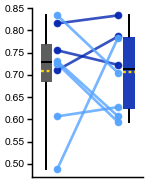

In [ ]:
fig_name = "nrem_sleep_fraction_ctrl_exp"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.1, 1.33))
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl_fracs,
        positions=[0.35],
        widths=0.04,
        color=NNXR_GRAY,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        exp_fracs,
        positions=[0.65],
        widths=0.04,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl_fracs_som, x_pos=0.39, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, ctrl_fracs_acr, x_pos=0.39, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, exp_fracs_som, x_pos=0.61, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, exp_fracs_acr, x_pos=0.61, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    for c, e in zip(ctrl_fracs_som, exp_fracs_som):
        ax.plot([0.39, 0.61], [c, e], color=SOM_BLUE, alpha=0.8, linewidth=4)
    for c, e in zip(ctrl_fracs_acr, exp_fracs_acr):
        ax.plot([0.39, 0.61], [c, e], color=ACR_BLUE, alpha=0.8, linewidth=4)
    
    ax.set_xlim(0.30, 0.70)
    ax.set_xticklabels([None, None])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [180]:
# ===== Adjust here =====
stat_name = fig_name
nnxr = ctrl_fracs
nnxo = exp_fracs
# =========================

_, p = shapiro(nnxr)
print(f"p-value for NNXr: {p}")

_, p = shapiro(nnxo)
print(f"p-value for NNXo: {p}")

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype="hedges")
stat = pg.ttest(nnxr, nnxo, paired=True)
acr.stats.write_stats_result(
    stat_name,
    "paired_ttest",
    test_statistic=stat["T"][0],
    p_value=stat["p-val"][0],
    effect_size_method="g",
    effect_size=hg,
    review=True,
)

src1 = pd.DataFrame({
    "variable": nnxr,  # data (e.g. SWA)
    "subject": np.arange(len(nnxr)),  # subject index
    "cond": "control_sleep_fraction",  # probe
})

src2 = pd.DataFrame({
    "variable": nnxo,  # data (e.g. SWA)
    "subject": np.arange(len(nnxo)),  # subject index
    "cond": "exp_sleep_fraction",  # probe
})
srcdat = pd.concat([src1, src2])
pu.write_source_data(srcdat, stat_name)
stat

p-value for NNXr: 0.2984138446285348
p-value for NNXo: 0.4312437891046255


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.015299,7,two-sided,0.988221,"[-0.12, 0.12]",0.007586,0.336,0.05004


In [181]:
state = 'REM'
ctrl_fracs = []
exp_fracs = []
for subject in fo_ctrl.subject.unique():
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_fracs.append(state_ctrl)
    exp_fracs.append(state_exp)

ctrl_fracs = np.array(ctrl_fracs)
exp_fracs = np.array(exp_fracs)
ctrl_som = []
exp_som = []
for subject in fo_ctrl.subject.unique():
    
    sub_type = acr.utils.sub_exp_types[subject]
    if sub_type != 'som':
        continue
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_som.append(state_ctrl)
    exp_som.append(state_exp)

ctrl_fracs_som = np.array(ctrl_som)
exp_fracs_som = np.array(exp_som)
ctrl_acr = []
exp_acr = []
for subject in fo_ctrl.subject.unique():
    
    sub_type = acr.utils.sub_exp_types[subject]
    if sub_type != 'acr':
        continue
    print(subject)
    state_ctrl = fo_ctrl.loc[fo_ctrl.subject == subject].st(state)['duration'].values[0]
    state_exp = fo.loc[fo.subject == subject].st(state)['duration'].values[0]
    ctrl_acr.append(state_ctrl)
    exp_acr.append(state_exp)

ctrl_fracs_acr = np.array(ctrl_acr)
exp_fracs_acr = np.array(exp_acr)

ACR_19
ACR_23
ACR_31
ACR_33
ACR_34
ACR_35
ACR_37
ACR_44
ACR_35
ACR_37
ACR_44
ACR_19
ACR_23
ACR_31
ACR_33
ACR_34


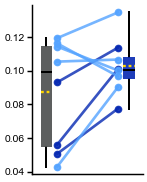

In [182]:
fig_name = "rem_sleep_fraction_ctrl_exp"
fig_path = os.path.join(nbroot, f"{fig_name}.svg")
with pp.destination('figma', style=style_path):
    f, ax = plt.subplots(1, 1, figsize=pp.scale(1.1, 1.33))
    ax, box = acr.plots.add_boxplot(
        ax,
        ctrl_fracs,
        positions=[0.35],
        widths=0.04,
        color=NNXR_GRAY,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax, box = acr.plots.add_boxplot(
        ax,
        exp_fracs,
        positions=[0.65],
        widths=0.04,
        color=SOM_BLUE,
        means=True,
        mean_color="gold",
        mean_linewidth=3.5,
        mean_linestyle="--",
        mean_dashes=(1.2, 1.2),
        alpha=0.9,
    )
    ax = acr.plots.add_data_points(
        ax, ctrl_fracs_som, x_pos=0.39, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, ctrl_fracs_acr, x_pos=0.39, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, exp_fracs_som, x_pos=0.61, color=SOM_BLUE, alpha=0.9, s=70, zorder=203
    )
    ax = acr.plots.add_data_points(
        ax, exp_fracs_acr, x_pos=0.61, color=ACR_BLUE, alpha=0.9, s=70, zorder=203
    )
    for c, e in zip(ctrl_fracs_som, exp_fracs_som):
        ax.plot([0.39, 0.61], [c, e], color=SOM_BLUE, alpha=0.8, linewidth=4)
    for c, e in zip(ctrl_fracs_acr, exp_fracs_acr):
        ax.plot([0.39, 0.61], [c, e], color=ACR_BLUE, alpha=0.8, linewidth=4)
    
    ax.set_xlim(0.30, 0.70)
    ax.set_xticklabels([None, None])
    f.savefig(fig_path, bbox_inches='tight', transparent=True)
    plt.show()

In [185]:
# ===== Adjust here =====
stat_name = fig_name
nnxr = ctrl_fracs
nnxo = exp_fracs
# =========================

_, p = shapiro(nnxr)
print(f"p-value for NNXr: {p}")

_, p = shapiro(nnxo)
print(f"p-value for NNXo: {p}")

hg = pg.compute_effsize(nnxr, nnxo, paired=True, eftype="hedges")
stat = pg.ttest(nnxr, nnxo, paired=True)

acr.stats.write_stats_result(
    stat_name,
    "paired_ttest",
    test_statistic=stat["T"][0],
    p_value=stat["p-val"][0],
    effect_size_method="g",
    effect_size=hg,
    review=True,
)

src1 = pd.DataFrame({
    "variable": nnxr,  # data (e.g. SWA)
    "subject": np.arange(len(nnxr)),  # subject index
    "cond": "control_sleep_fraction",  # probe
})

src2 = pd.DataFrame({
    "variable": nnxo,  # data (e.g. SWA)
    "subject": np.arange(len(nnxo)),  # subject index
    "cond": "exp_sleep_fraction",  # probe
})
srcdat = pd.concat([src1, src2])
pu.write_source_data(srcdat, stat_name)
stat

p-value for NNXr: 0.07065807201697381
p-value for NNXo: 0.8313741861023712


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-1.73736,7,two-sided,0.125892,"[-0.04, 0.01]",0.595844,0.972,0.308206
